In [1]:
import pandas as pd
sf = pd.read_csv('Auto_MPG.csv')
sf.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,chevrolet
1,15.0,8,350.0,165.0,3693,11.5,70,buick
2,18.0,8,318.0,150.0,3436,11.0,70,plymouth
3,16.0,8,304.0,150.0,3433,12.0,70,amc
4,17.0,8,302.0,140.0,3449,10.5,70,ford


In [2]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      392 non-null float64
weight          398 non-null int64
acceleration    398 non-null float64
model_year      398 non-null int64
origin          398 non-null object
dtypes: float64(4), int64(3), object(1)
memory usage: 25.0+ KB


In [3]:
sf.dropna(inplace=True)

In [4]:
sf.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000


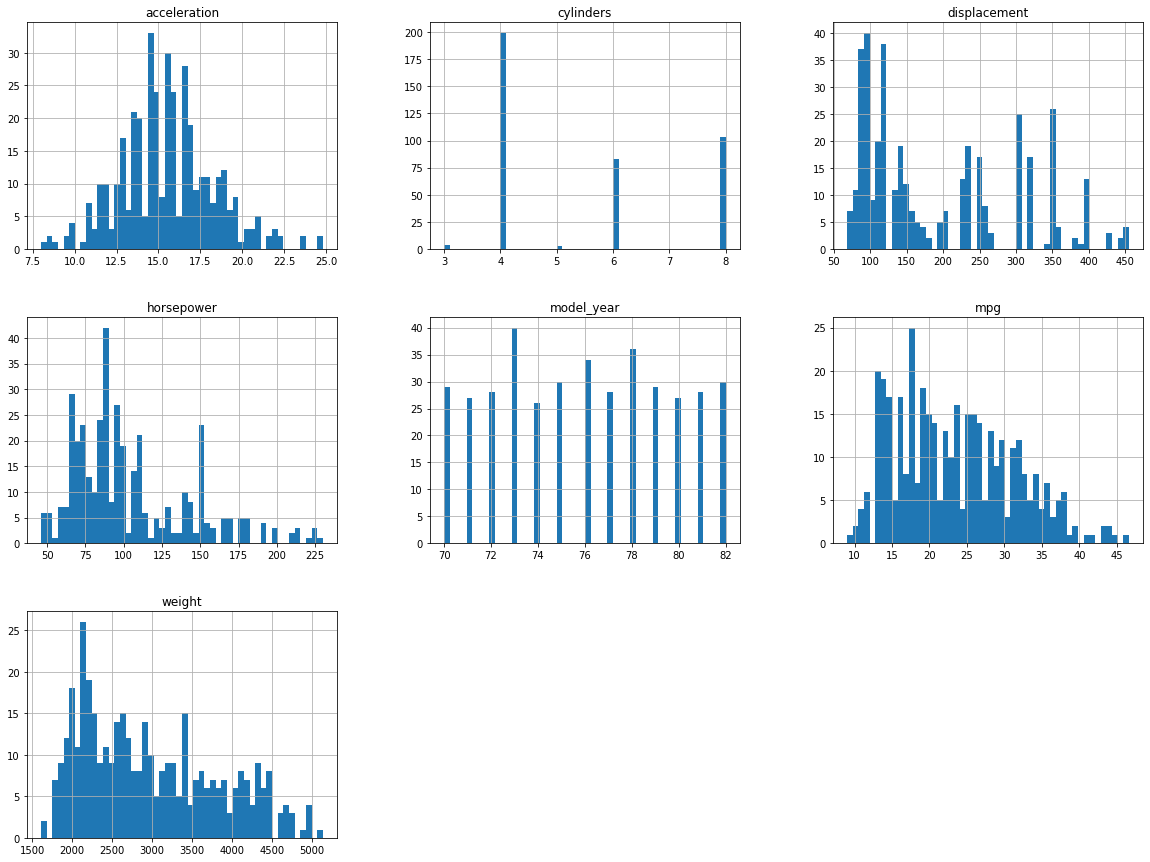

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
sf.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

Observations: 

1. These variables have very different scales. We will discuss this later in this chapter when we explore feature scaling.

2. Many histograms are right skewed: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

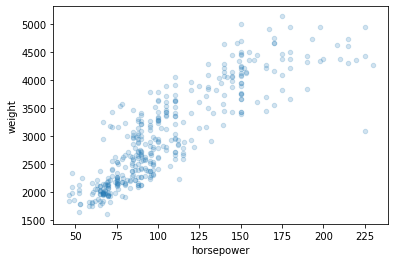

In [6]:
sf.plot(kind="scatter", x="horsepower", y="weight", alpha=0.2)
plt.savefig('map1.png')

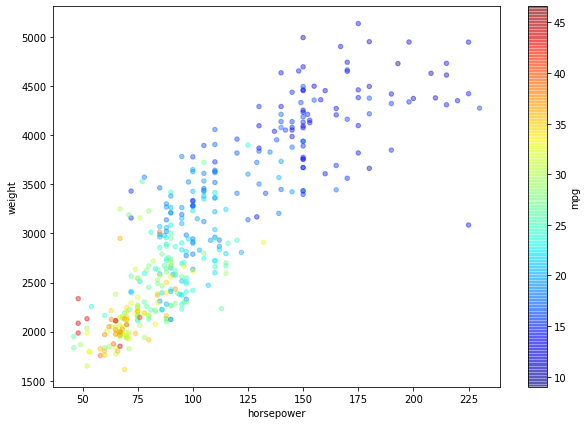

In [7]:
sf.plot(kind="scatter", x="horsepower", y="weight", alpha=0.4, figsize=(10,7),
    c="mpg", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.savefig('map2.png')

Now let’s look at how much each independent variable correlates with the last sold price.

In [8]:
corr_matrix = sf.corr()
corr_matrix["mpg"].sort_values(ascending=False)

mpg             1.000000
model_year      0.580541
acceleration    0.423329
cylinders      -0.777618
horsepower     -0.778427
displacement   -0.805127
weight         -0.832244
Name: mpg, dtype: float64

The miles per gallon (mpg) tends to go up when the model year and acceleration go up. You can see a strong negative correlation between the weight, displacement, horsepower, cylinders and the miles per gallon. 

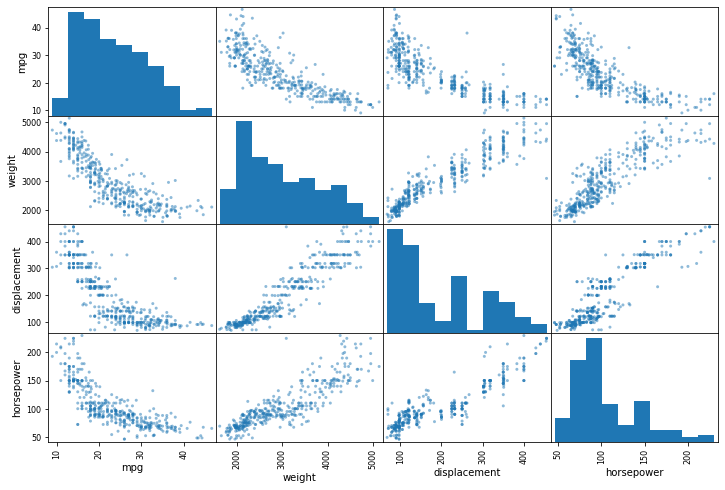

In [9]:
from pandas.plotting import scatter_matrix

attributes = ["mpg", "weight", "displacement", "horsepower"]
scatter_matrix(sf[attributes], figsize=(12, 8))
plt.savefig('matrix.png')

The most promising variable to predict the miles per gallon is the weight, so let’s zoom in on their correlation scatterplot

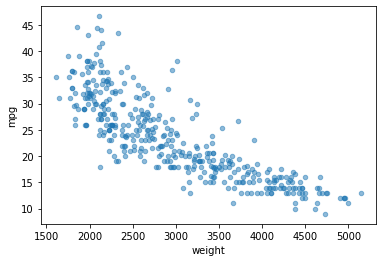

In [10]:
sf.plot(kind="scatter", x="weight", y="mpg", alpha=0.5)
plt.savefig('scatter.png')

First, the correlation is indeed very strong; you can clearly see the downward trend and the points are not too dispersed.

Because each origin has the different mpg, what we really want is the mpg per weight. So, we add a new variable "mpg_per_weight". 

In [11]:
sf['mpg_per_weight'] = sf['mpg']/sf['weight']

In [12]:
corr_matrix = sf.corr()
corr_matrix["mpg"].sort_values(ascending=False)

mpg               1.000000
mpg_per_weight    0.961965
model_year        0.580541
acceleration      0.423329
cylinders        -0.777618
horsepower       -0.778427
displacement     -0.805127
weight           -0.832244
Name: mpg, dtype: float64

Fortunately, the new pmpg_per_weight variable has only very strong positive correlation with the mpg. We still need this varaible for grouping origin.

In [13]:
sf.origin.unique()

array(['chevrolet', 'buick', 'plymouth', 'amc', 'ford', 'pontiac',
       'dodge', 'toyota', 'datsun', 'volkswagen', 'peugeot', 'audi',
       'saab', 'bmw', 'hi', 'mercury', 'opel', 'fiat', 'oldsmobile',
       'chrysler', 'mazda', 'volvo', 'renault', 'honda', 'subaru',
       'capri', 'Volkswagen', 'mercedes-benz', 'cadillac', 'triumph',
       'nissan'], dtype=object)

#### Also there are 31 origins in the data, we are going to group them.

In [14]:
len(sf['origin'].value_counts())

31

In [15]:
freq = sf.groupby('origin').count()['horsepower']
#mean_mpg: average mpg per weight
mean = sf.groupby('origin').mean()['mpg_per_weight']
cluster = pd.concat([freq, mean], axis=1)
cluster['origin'] = cluster.index

In [16]:
cluster.columns = ['freq', 'mpg_per_weight','origin']

In [17]:
cluster.describe()

,freq,mpg_per_weight
count,31.000000,31.000000
mean,12.645161,0.009938
std,12.924262,0.004211
min,1.000000,0.001902
25%,3.000000,0.006555
50%,8.000000,0.009159
75%,16.500000,0.013709
max,48.000000,0.018220


Cluster the origin into three groups: 1. low mpg, 2. high mpg low horsepower, 3. high mpg high horsepower

In [18]:
cluster1 = cluster[cluster.mpg_per_weight < 0.009]
cluster1.index

Index(['amc', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'dodge', 'ford',
       'hi', 'mercedes-benz', 'mercury', 'oldsmobile', 'peugeot', 'plymouth',
       'pontiac', 'volvo'],
      dtype='object', name='origin')

In [19]:
cluster_temp = cluster[cluster.mpg_per_weight >= 0.009]
cluster2 = cluster_temp[cluster_temp.freq <8]
cluster2.index

Index(['Volkswagen', 'audi', 'bmw', 'capri', 'nissan', 'opel', 'renault',
       'saab', 'subaru', 'triumph'],
      dtype='object', name='origin')

In [20]:
cluster3 = cluster_temp[cluster_temp.freq >=8]
cluster3.index

Index(['datsun', 'fiat', 'honda', 'mazda', 'toyota', 'volkswagen'], dtype='object', name='origin')

Add group column based on the clusters

In [21]:
def get_group(x):
    if x in cluster1.index:
        return 'low_mpg'
    elif x in cluster2.index:
        return 'high_mpg_low_freq'
    else:
        return 'high_mpg_high_freq'
sf['group'] = sf.origin.apply(get_group)

Now let's preprocess the categorical input feature, model_year

In [22]:
sf.model_year.unique()

array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82], dtype=int64)

In [23]:
sf['model'] = pd.cut(sf['model_year'], [69,74,79,82] , labels= ["Early70s", "Late70s", "Early80s"])
sf

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg_per_weight,group,model
0,18.0,8,307.0,130.0,3504,12.0,70,chevrolet,0.005137,low_mpg,Early70s
1,15.0,8,350.0,165.0,3693,11.5,70,buick,0.004062,low_mpg,Early70s
2,18.0,8,318.0,150.0,3436,11.0,70,plymouth,0.005239,low_mpg,Early70s
3,16.0,8,304.0,150.0,3433,12.0,70,amc,0.004661,low_mpg,Early70s
4,17.0,8,302.0,140.0,3449,10.5,70,ford,0.004929,low_mpg,Early70s
...,...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,ford,0.009677,low_mpg,Early80s
394,44.0,4,97.0,52.0,2130,24.6,82,Volkswagen,0.020657,high_mpg_low_freq,Early80s
395,32.0,4,135.0,84.0,2295,11.6,82,dodge,0.013943,low_mpg,Early80s
396,28.0,4,120.0,79.0,2625,18.6,82,ford,0.010667,low_mpg,Early80s


In [24]:
sf.isna().sum()

mpg               0
cylinders         0
displacement      0
horsepower        0
weight            0
acceleration      0
model_year        0
origin            0
mpg_per_weight    0
group             0
model             0
dtype: int64

In [25]:
sf.drop(sf.columns[[6,7, 8]], axis=1, inplace=True)
sf.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,group,model
0,18.0,8,307.0,130.0,3504,12.0,low_mpg,Early70s
1,15.0,8,350.0,165.0,3693,11.5,low_mpg,Early70s
2,18.0,8,318.0,150.0,3436,11.0,low_mpg,Early70s
3,16.0,8,304.0,150.0,3433,12.0,low_mpg,Early70s
4,17.0,8,302.0,140.0,3449,10.5,low_mpg,Early70s


Create dummy variables for two categorical variables.

In [26]:
X = sf[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'group', 
         'model']]
Y = sf['mpg']
#create dummy variables for groups
n = pd.get_dummies(sf.group)
X = pd.concat([X, n], axis=1)

In [27]:
m = pd.get_dummies(sf.model)
X = pd.concat([X, m], axis=1)

In [28]:
drops = ['group', 'model']
X.drop(drops, inplace=True, axis=1)

In [29]:
X.head()

,cylinders,displacement,horsepower,weight,acceleration,high_mpg_high_freq,high_mpg_low_freq,low_mpg,Early70s,Late70s,Early80s
0,8,307.0,130.0,3504,12.0,0,0,1,1,0,0
1,8,350.0,165.0,3693,11.5,0,0,1,1,0,0
2,8,318.0,150.0,3436,11.0,0,0,1,1,0,0
3,8,304.0,150.0,3433,12.0,0,0,1,1,0,0
4,8,302.0,140.0,3449,10.5,0,0,1,1,0,0


In [30]:
X.shape

(392, 11)

In [31]:
Y.shape

(392,)

Standardization of the data

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [34]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Done! We now have a working Linear Regression model.

In [35]:
y_pred = regressor.predict(X_test)
print('Liner Regression R squared: %.4f' % regressor.score(X_test, y_test))

Liner Regression R squared: 0.8306


So, in our model, 83.06% of the variability in Y can be explained using X. It is sure exciting.

Calculate root-mean-square error (RMSE)

In [36]:
import numpy as np
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Liner Regression RMSE: %.4f' % lin_rmse)

Liner Regression RMSE: 3.2285


Our model was able to predict the miles per gallon of every car in the test set within 3.2285 miles of the real miles per gallon.

Calculate mean absolute error (MAE)

In [37]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_pred, y_test)
print('Liner Regression MAE: %.4f' % lin_mae)

Liner Regression MAE: 2.4628


let’s try a more complex model to see whether results can be improved - the RandomForestRegressor

In [38]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [39]:
print('Random Forest R squared": %.4f' % forest_reg.score(X_test, y_test))

Random Forest R squared": 0.8300


In [40]:
y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_pred, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)

Random Forest RMSE: 3.2343


Worse! Let's try one more.

In [41]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [42]:
print('Gradient Boosting R squared": %.4f' % model.score(X_test, y_test))

Gradient Boosting R squared": 0.8257


In [43]:
y_pred = model.predict(X_test)
model_mse = mean_squared_error(y_pred, y_test)
model_rmse = np.sqrt(model_mse)
print('Gradient Boosting RMSE: %.4f' % model_rmse)

Gradient Boosting RMSE: 3.2747


I would consider the Random Forest Regressor as our final model, let's print out feature importance

In [44]:
feature_labels = np.array(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 
                           'high_mpg_high_freq', 'high_mpg_low_freq', 'low_mpg', 'Early70s', 'Late80s', 'Early80s'])
importance = forest_reg.feature_importances_
feature_indexes_by_importance = importance.argsort()[::-1]
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

cylinders-30.43%
displacement-22.83%
weight-21.92%
horsepower-14.12%
Early80s-4.94%
acceleration-3.47%
Early70s-1.28%
Late80s-0.39%
low_mpg-0.35%
high_mpg_high_freq-0.17%
high_mpg_low_freq-0.11%
